# 7.2  RNN手写字体识别


**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
## 设置图像风格
import seaborn as sns
sns.set(font_scale=1.5,style="white") 

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data as Data
from torchvision import transforms
import hiddenlayer as hl

### 数据准备

In [3]:
## 准备训练数据集Minist
train_data  = torchvision.datasets.MNIST(
    root = "./data/MNIST", # 数据的路径
    train = True, # 只使用训练数据集
    # 将数据转化为torch使用的张量,取汁范围为［0，1］
    transform  = transforms.ToTensor(),
    download= False # 因为数据已经下载过，所以这里不再下载
)
## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 2, # 使用两个进程 
)

##  可视化训练数据集的一个batch的样本来查看图像内容
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸，都是torch格式的数据
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
## 准备需要使用的测试数据集
test_data  = torchvision.datasets.MNIST(
    root = "./data/MNIST", # 数据的路径
    train = False, # 不使用训练数据集
    transform  = transforms.ToTensor(),
    download= False # 因为数据已经下载过，所以这里不再下载
)
## 定义一个数据加载器
test_loader = Data.DataLoader(
    dataset = test_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 2, # 使用两个进程 
)
##  可视化训练数据集的一个batch的样本来查看图像内容
for step, (b_x, b_y) in enumerate(test_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸，都是torch格式的数据
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


### 搭建RNN模型

In [5]:
class RNNimc(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        """
        input_dim:输入数据的维度(图片每行的数据像素点)
        hidden_dim: RNN神经元个数
        layer_dim: RNN的层数
        output_dim:隐藏层输出的维度(分类的数量)
        """
        super(RNNimc, self).__init__()
        self.hidden_dim = hidden_dim ## RNN神经元个数
        self.layer_dim = layer_dim ## RNN的层数
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim,
                          batch_first=True, nonlinearity='relu')
        
        # 连接全连阶层
        self.fc1 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # x:[batch, time_step, input_dim]
        # 本例中time_step＝图像所有像素数量／input_dim
        # out:[batch, time_step, output_size]
        # h_n:[layer_dim, batch, hidden_dim]
        out, h_n = self.rnn(x, None) # None表示h0会使用全0进行初始化
        # 选取最后一个时间点的out输出
        out = self.fc1(out[:, -1, :]) 
        return out
    

In [6]:
## 模型的调用
input_dim=28   # 图片每行的像素数量
hidden_dim=128  # RNN神经元个数
layer_dim = 1  # RNN的层数
output_dim=10  # 隐藏层输出的维度(10类图像)
MyRNNimc = RNNimc(input_dim, hidden_dim, layer_dim, output_dim)
print(MyRNNimc)

RNNimc(
  (rnn): RNN(28, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/onnx/symbolic.py:173: UserWarning: ONNX export failed on RNN/GRU/LSTM because batch_first not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


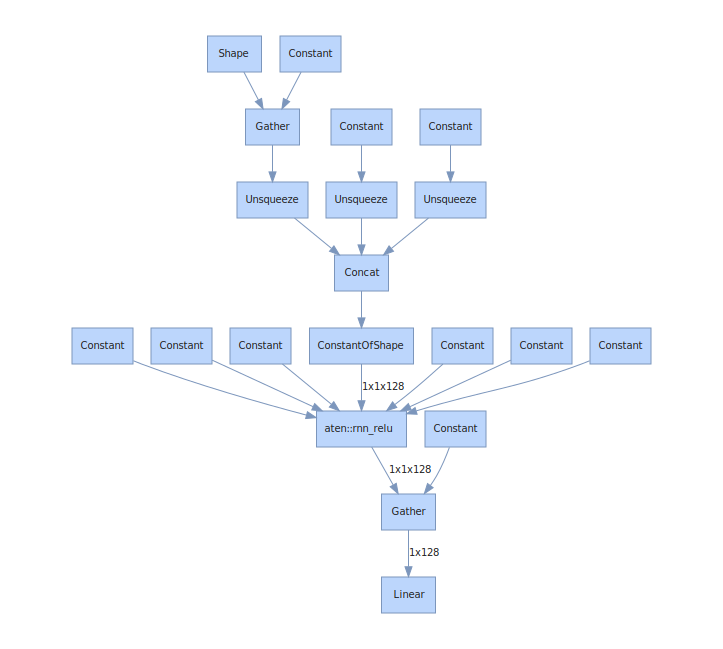

In [7]:
## 可视化卷积神经网络
## 输入:[batch, time_step, input_dim]
hl_graph = hl.build_graph(MyRNNimc, torch.zeros([1, 28, 28]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()  
hl_graph

In [43]:
## 将可视化的网路保存为图片,默认格式为pdf
hl_graph.save("data/chap7/MyRNNimc_hl.png", format="png")

### 对模型进行训练

In [8]:
## 对模型进行训练
optimizer = torch.optim.RMSprop(MyRNNimc.parameters(), lr=0.0003)  
criterion = nn.CrossEntropyLoss()   # 损失函数
train_loss_all = []
train_acc_all = []
test_loss_all = []
test_acc_all = []
num_epochs = 30
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    MyRNNimc.train() ## 设置模型为训练模式
    corrects = 0
    train_num  = 0
    for step,(b_x, b_y) in enumerate(train_loader):
        # input :[batch, time_step, input_dim]
        xdata = b_x.view(-1, 28, 28)
        output = MyRNNimc(xdata)     
        pre_lab = torch.argmax(output,1)
        loss = criterion(output, b_y) 
        optimizer.zero_grad()        
        loss.backward()       
        optimizer.step()  
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        train_num += b_x.size(0)
    ## 计算经过一个epoch的训练后在训练集上的损失和精度
    train_loss_all.append(loss / train_num)
    train_acc_all.append(corrects.double().item()/train_num)
    print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
        epoch, train_loss_all[-1], train_acc_all[-1]))
    ## 设置模型为验证模式
    MyRNNimc.eval()
    corrects = 0
    test_num  = 0
    for step,(b_x, b_y) in enumerate(test_loader):
        # input :[batch, time_step, input_dim]
        xdata = b_x.view(-1, 28, 28)
        output = MyRNNimc(xdata)     
        pre_lab = torch.argmax(output,1)
        loss = criterion(output, b_y) 
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        test_num += b_x.size(0)
    ## 计算经过一个epoch的训练后在测试集上的损失和精度
    test_loss_all.append(loss / test_num)
    test_acc_all.append(corrects.double().item()/test_num)
    print('{} Test Loss: {:.4f}  Test Acc: {:.4f}'.format(
        epoch, test_loss_all[-1], test_acc_all[-1]))


Epoch 0/29
0 Train Loss: 0.0004  Train Acc: 0.6963
0 Test Loss: 0.0010  Test Acc: 0.8417
Epoch 1/29
1 Train Loss: 0.0001  Train Acc: 0.8569
1 Test Loss: 0.0006  Test Acc: 0.8811
Epoch 2/29
2 Train Loss: 0.0001  Train Acc: 0.8982
2 Test Loss: 0.0001  Test Acc: 0.9192
Epoch 3/29
3 Train Loss: 0.0000  Train Acc: 0.9222
3 Test Loss: 0.0001  Test Acc: 0.9367
Epoch 4/29
4 Train Loss: 0.0001  Train Acc: 0.9345
4 Test Loss: 0.0001  Test Acc: 0.9383
Epoch 5/29
5 Train Loss: 0.0002  Train Acc: 0.9444
5 Test Loss: 0.0008  Test Acc: 0.9235
Epoch 6/29
6 Train Loss: 0.0001  Train Acc: 0.9501
6 Test Loss: 0.0001  Test Acc: 0.9360
Epoch 7/29
7 Train Loss: 0.0001  Train Acc: 0.9555
7 Test Loss: 0.0005  Test Acc: 0.9526
Epoch 8/29
8 Train Loss: 0.0001  Train Acc: 0.9595
8 Test Loss: 0.0000  Test Acc: 0.9588
Epoch 9/29
9 Train Loss: 0.0001  Train Acc: 0.9629
9 Test Loss: 0.0000  Test Acc: 0.9611
Epoch 10/29
10 Train Loss: 0.0000  Train Acc: 0.9667
10 Test Loss: 0.0000  Test Acc: 0.9680
Epoch 11/29
11 Tra

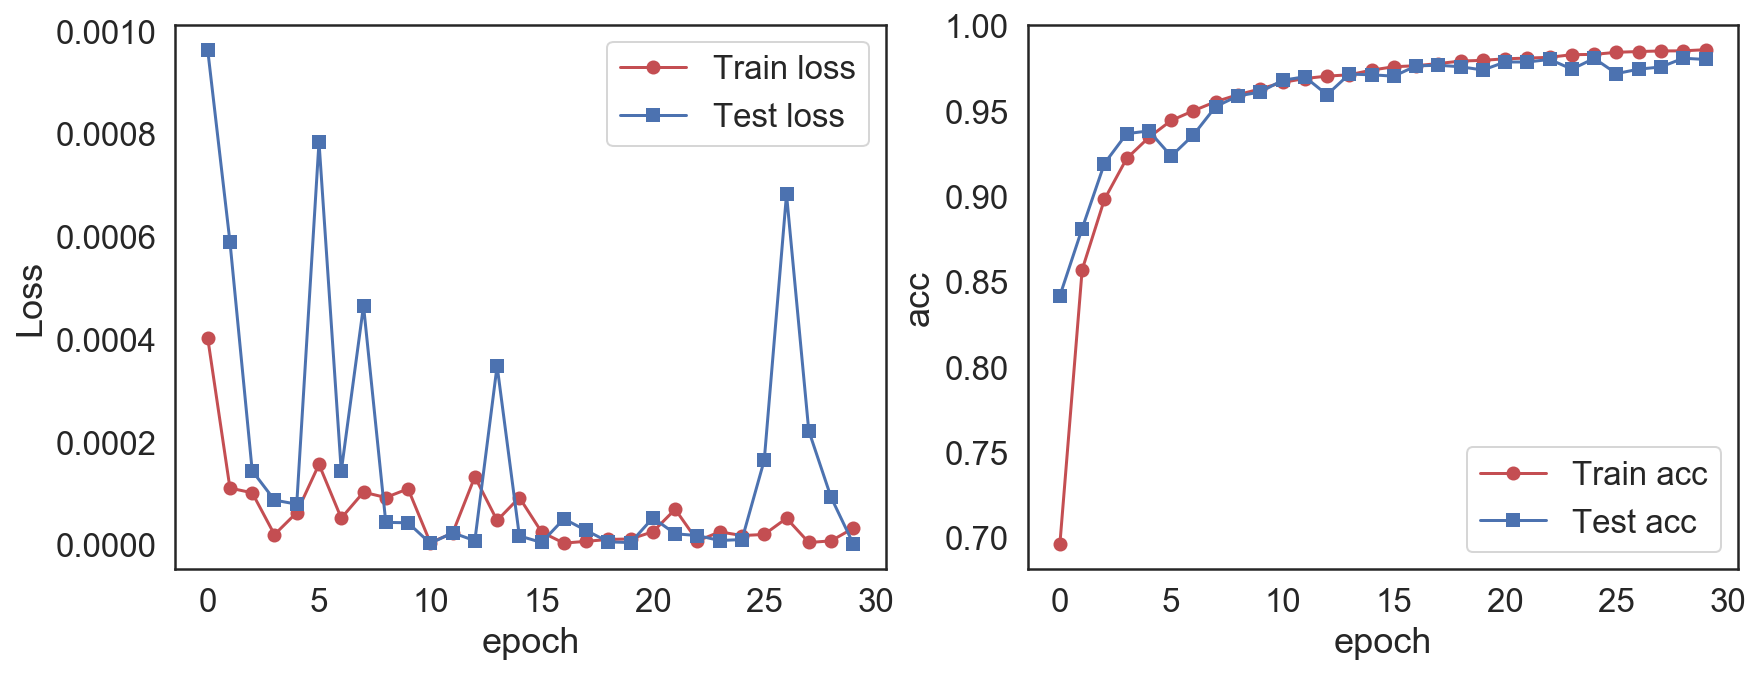

In [15]:
## 可视化模型训练过程中
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_loss_all,"ro-",label = "Train loss")
plt.plot(test_loss_all,"bs-",label = "Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_acc_all,"ro-",label = "Train acc")
plt.plot(test_acc_all,"bs-",label = "Test acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()